# Figures for Yeager et al., 2025: Efficient Drift Correction of Initialized Earth System Predictions
### CESM2-DP analysis

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
import os
import nc_time_axis
%matplotlib inline

# import plotting and other utilities 
# https://github.com/sgyeager/mypyutils
from mypyutils import calendar_utils as cal
from mypyutils import mapplot_utils as maps
from mypyutils import colorbar_utils as cbars
from mypyutils import regrid_utils as regrid
from mypyutils import io_utils as io
from mypyutils import stat_utils as stat

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2024.2.0'

## Preprocessing:  Data I/O using Dask

### Create Dask Cluster

In [57]:
try:
    client.shutdown()
except:
    pass

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='32GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=32GB',
        account='P06010014',
        walltime='02:30:00',
        local_directory='/glade/derecho/scratch/yeager/',
        log_directory='/glade/derecho/scratch/yeager/',
        interface='ext',
        job_script_prologue=[
        f'export ESMFMKFILE={os.environ["ESMFMKFILE"]}'])

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        "distributed.scheduler.worker-saturation": 1.0,
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(50) 
client

<Client: 'tcp://128.117.208.179:40713' processes=0 threads=0, memory=0 B>

### Read in CESM2-DP data

In [4]:
datadir = '/glade/derecho/scratch/yeager/YeagerEA_EffDriftCorr/data/'

In [5]:
cesm2dp_ann = xr.open_dataset(datadir+'CESM2-DP_NOV.TS.1960-2020.nc').chunk({'M':1})
cesm2dp_ann['TS'] = cesm2dp_ann['TS'].astype('float32')

In [7]:
climoIC_ann = xr.open_dataset(datadir+'CESM2-DP_NOV.TS.climoIC.nc').chunk({'M':1})
climoIC_ann['TS'] = climoIC_ann['TS'].astype('float32')

### Get Observed TS

In [8]:
cruhad_mon = xr.open_dataset(datadir+'merged_CRU-TS4.05_HadISST.TS.1960-2020.fv09.nc').astype('float32')

In [12]:
cruhad = cruhad_mon['TS'].groupby('time.year').mean('time').rename({'year':'time'})

## Obs climatology and anomalies

In [14]:
climy0 = 1991
climy1 = 2020

In [15]:
%%time
obs_clim = cruhad.sel(time=slice(str(climy0),str(climy1))).mean('time')
obs_anom = cruhad - obs_clim

CPU times: user 23.2 ms, sys: 8.23 ms, total: 31.4 ms
Wall time: 228 ms


### De-drift (using various methods)

In [16]:
%%time
# Compute de-drifted anomalies from specified climatology
cesm2dp_ann_time = cesm2dp_ann.time.load()
cesm2dp_anom_meth2,cesm2dp_clim = stat.remove_annual_drift(cesm2dp_ann['TS'],cesm2dp_ann_time,climy0,climy1)

CPU times: user 1.62 s, sys: 178 ms, total: 1.79 s
Wall time: 13.1 s


In [17]:
%%time
# Method 2, but only 1 member
iterations = 100
cesm2dp_anom_meth2_1mem,cesm2dp_clim_1mem = stat.remove_drift_nmem(cesm2dp_ann['TS'].drop_vars('M'),cesm2dp_ann_time,climy0,climy1,1,iterations,annual=True)

CPU times: user 7.54 s, sys: 117 ms, total: 7.66 s
Wall time: 8.13 s


/glade/work/yeager/conda-envs/mypythonenv3/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(


In [18]:
%%time
# Method 2, but only 2 member
iterations = 100
cesm2dp_anom_meth2_2mem,cesm2dp_clim_2mem = stat.remove_drift_nmem(cesm2dp_ann['TS'].drop_vars('M'),cesm2dp_ann_time,climy0,climy1,2,iterations,annual=True)

CPU times: user 7.66 s, sys: 67.1 ms, total: 7.73 s
Wall time: 8.24 s


/glade/work/yeager/conda-envs/mypythonenv3/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(


In [19]:
## Use Method 3 to compute anomalies (subtract climoIC ensemble):
cesm2dp_anom_meth3 = cesm2dp_ann['TS'] - climoIC_ann['TS'].mean('M').squeeze()

In [20]:
## Use Method 1 to compute anomalies (subtract observed climo):
cesm2dp_anom_meth1 = cesm2dp_ann['TS'] - obs_clim

In [21]:
%%time
cesm2dp_anom_meth2_1mem = cesm2dp_anom_meth2_1mem.transpose('iteration','Y','L','M','lat','lon').chunk({'L':10,'M':20}).persist()
daskout = wait(cesm2dp_anom_meth2_1mem)

CPU times: user 15.3 s, sys: 744 ms, total: 16.1 s
Wall time: 33.9 s


In [22]:
%%time
cesm2dp_anom_meth2_2mem = cesm2dp_anom_meth2_2mem.transpose('iteration','Y','L','M','lat','lon').chunk({'L':10,'M':20}).persist()
daskout = wait(cesm2dp_anom_meth2_2mem)

CPU times: user 24 s, sys: 793 ms, total: 24.8 s
Wall time: 33 s


## Latlon Bias Comparison Plot

In [24]:
lon = cesm2dp_ann.lon
lat = cesm2dp_ann.lat

In [25]:
%%time
climobias2 = cesm2dp_clim - obs_clim
climobias2 = climobias2.load()

CPU times: user 2.71 s, sys: 226 ms, total: 2.94 s
Wall time: 14.1 s


In [26]:
%%time
climobias2_1mem = cesm2dp_clim_1mem - obs_clim
#climobias2_1mem = climobias2_1mem.load()

CPU times: user 3.03 ms, sys: 231 µs, total: 3.26 ms
Wall time: 3.27 ms


In [27]:
%%time
climobias2_2mem = cesm2dp_clim_2mem - obs_clim
#climobias2_2mem = climobias2_2mem.load()

CPU times: user 5.84 ms, sys: 148 µs, total: 5.99 ms
Wall time: 6 ms


In [28]:
%%time
climobias3 = climoIC_ann['TS'].mean('M').squeeze() - obs_clim
climobias3 = climobias3.load()

CPU times: user 98.9 ms, sys: 165 µs, total: 99 ms
Wall time: 286 ms


In [29]:
%%time
cesm2dp_climodiff2_1mem = (climobias2_1mem - climobias2).std('iteration').load()
cesm2dp_climodiff2_2mem = (climobias2_2mem - climobias2).std('iteration').load()

CPU times: user 29.2 s, sys: 710 ms, total: 29.9 s
Wall time: 39.1 s


## Figure 10

CPU times: user 19.5 s, sys: 272 ms, total: 19.8 s
Wall time: 22.1 s


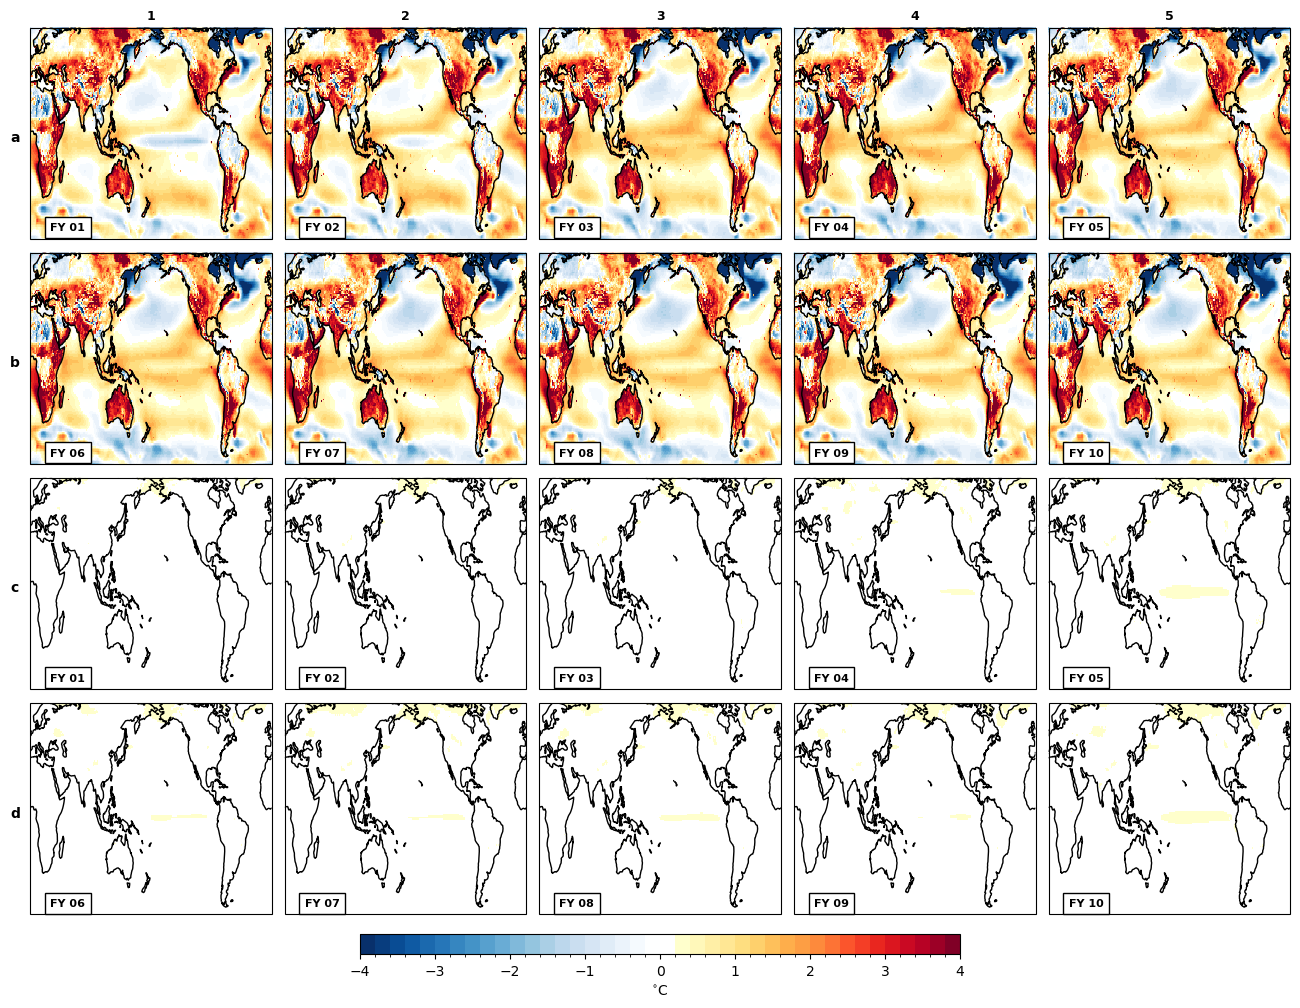

In [30]:
%%time
ci = 0.2
cmin = -4
cmax = 4

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=5
proj = ccrs.PlateCarree(central_longitude=180)

fsize=10
fweight='bold'
cmap = "blue2red"

for i in range(10):
    leadstr = 'FY '+str(i+1).zfill(2)
    labstr = 'a'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, climobias2.isel(L=i), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<5):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        #ax1.set_ylabel('a',fontsize=9,weight='bold')
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 5): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

tmp = cesm2dp_climodiff2_1mem
for i in range(10):
    leadstr = 'FY '+str(i+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=i), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+11,proj,grid='latlon',cmap=cmap)
    if (i == 0):
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 5): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    #ax1.set_title(leadstr,loc='center',fontsize=9)
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08,left=0.15)
cbar_ax = fig.add_axes([0.37, 0.04, 0.4, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'$^{\circ}$C', orientation='horizontal')

plt.savefig('Fig10.png')

## Supplementary Figure 9

CPU times: user 20.5 s, sys: 151 ms, total: 20.6 s
Wall time: 22.3 s


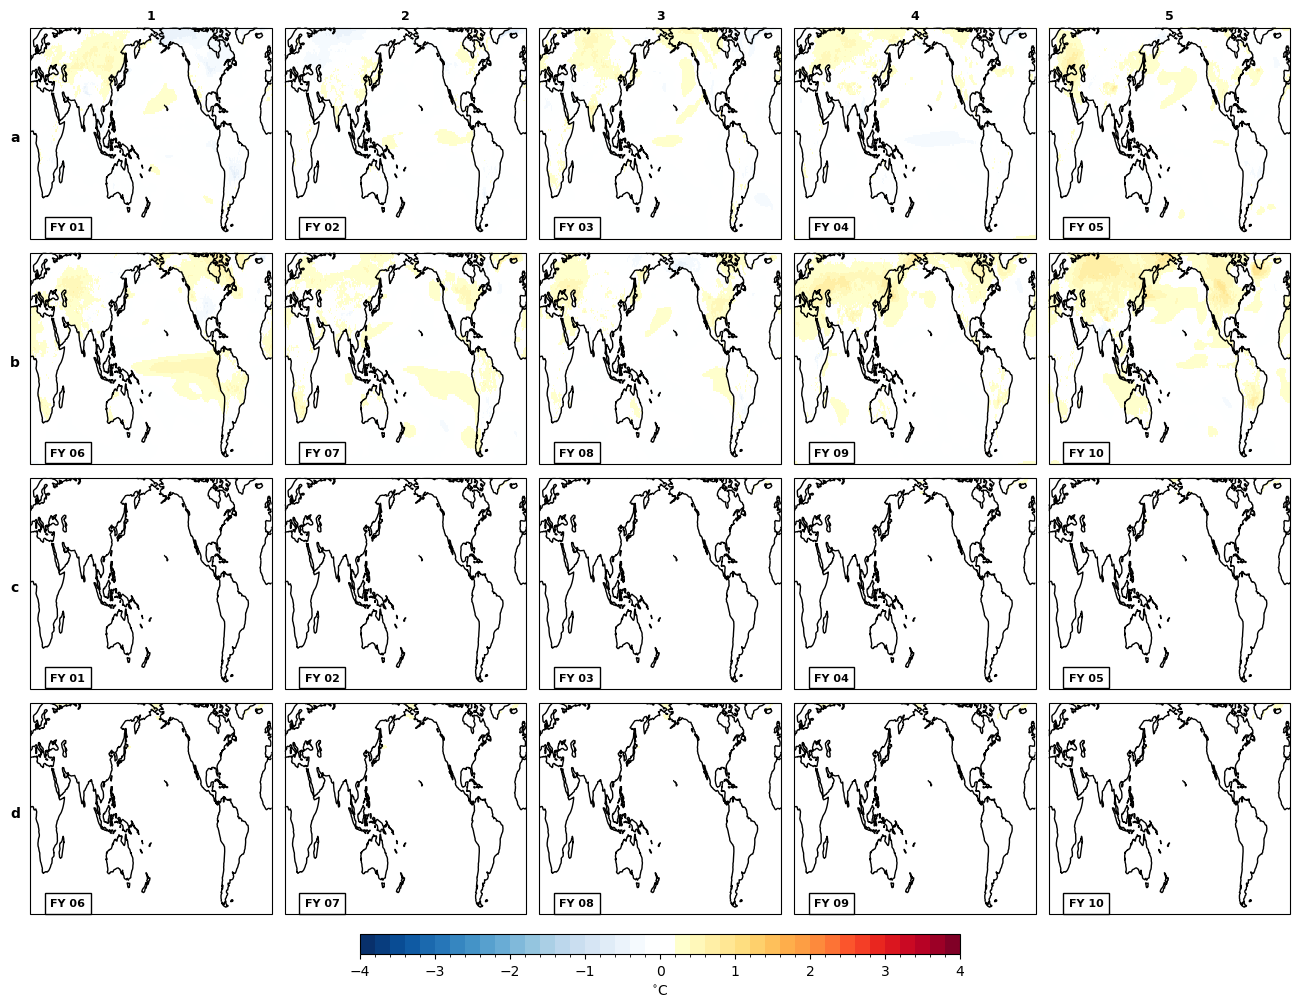

In [31]:
%%time
ci = 0.2
cmin = -4
cmax = 4

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=5
proj = ccrs.PlateCarree(central_longitude=180)

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = climobias3 - climobias2
for i in range(10):
    leadstr = 'FY '+str(i+1).zfill(2)
    labstr = 'a'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=i), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<5):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        #ax1.set_ylabel('a',fontsize=9,weight='bold')
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 5): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

tmp = cesm2dp_climodiff2_2mem
for i in range(10):
    leadstr = 'FY '+str(i+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=i), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+11,proj,grid='latlon',cmap=cmap)
    if (i == 0):
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 5): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    #ax1.set_title(leadstr,loc='center',fontsize=9)
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08,left=0.15)
cbar_ax = fig.add_axes([0.37, 0.04, 0.4, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'$^{\circ}$C', orientation='horizontal')

plt.savefig('Fig_supp09.png')

## Regional TS

In [32]:
chunks = {'M':20,'L':10}

In [33]:
%%time 
cesm2dp_anom_meth2 = cesm2dp_anom_meth2.chunk(chunks).persist()
daskout = wait(cesm2dp_anom_meth2)

CPU times: user 914 ms, sys: 57.7 ms, total: 972 ms
Wall time: 3.67 s


In [34]:
%%time 
cesm2dp_anom_meth1 = cesm2dp_anom_meth1.chunk(chunks).persist()
daskout = wait(cesm2dp_anom_meth1)

CPU times: user 3.56 s, sys: 244 ms, total: 3.81 s
Wall time: 17 s


In [35]:
%%time 
cesm2dp_anom_meth3 = cesm2dp_anom_meth3.chunk(chunks).persist()
daskout = wait(cesm2dp_anom_meth3)

CPU times: user 466 ms, sys: 46.9 ms, total: 513 ms
Wall time: 2.08 s


In [36]:
reglonlat = [[-220.+360,-145.+360.,25.,45.],[-190.+360,-90.+360.,-10.,10.],[-210.+360,-160.+360.,-50.,-15.],
            [-50.+360.,-10.+360.,50.,60.]]
regstr = ['IPO1','IPO2','IPO3', 'SPG']
regions1 = xr.DataArray(reglonlat,
                       dims=["region", "lonlat"],
                       coords=[("region",regstr),("lonlat",['lon0','lon1','lat0','lat1'])]
                      )
nregion1 = regions1.region.size

In [37]:
def reg_avg(ds,wgt,region):
    tmp_ds = ds.sel(lon=slice(region[0],region[1])).sel(lat=slice(region[2],region[3]))
    tmp_wgt = wgt.sel(lat=slice(region[2],region[3]))
    ds_out = tmp_ds.weighted(tmp_wgt).mean(['lat','lon'])
    return ds_out

def compute_ipo(ds,wgt,reg1,reg2,reg3):
    ds_out1 = reg_avg(ds,wgt,reg1)
    ds_out2 = reg_avg(ds,wgt,reg2)
    ds_out3 = reg_avg(ds,wgt,reg3)
    ds_out = (ds_out2 - 0.5*(ds_out1+ds_out3))
    return ds_out

In [38]:
coswgts = np.cos(np.deg2rad(lat))

In [39]:
%%time
ipo_meth2_1mem = compute_ipo(cesm2dp_anom_meth2_1mem.chunk(chunks).transpose('iteration','Y','L','M','lat','lon'),coswgts,reglonlat[0],reglonlat[1],reglonlat[2]).load()

CPU times: user 2.23 s, sys: 108 ms, total: 2.34 s
Wall time: 6.98 s


In [40]:
%%time
ipo_meth2_2mem = compute_ipo(cesm2dp_anom_meth2_2mem.chunk(chunks).transpose('iteration','Y','L','M','lat','lon'),coswgts,reglonlat[0],reglonlat[1],reglonlat[2]).load()

CPU times: user 896 ms, sys: 40.3 ms, total: 936 ms
Wall time: 1.09 s


In [41]:
%%time
ipo_meth1 = compute_ipo(cesm2dp_anom_meth1,coswgts,reglonlat[0],reglonlat[1],reglonlat[2]).load()

CPU times: user 128 ms, sys: 764 µs, total: 128 ms
Wall time: 269 ms


In [42]:
%%time
ipo_meth2 = compute_ipo(cesm2dp_anom_meth2,coswgts,reglonlat[0],reglonlat[1],reglonlat[2]).load()

CPU times: user 117 ms, sys: 4.58 ms, total: 121 ms
Wall time: 273 ms


In [43]:
%%time
ipo_meth3 = compute_ipo(cesm2dp_anom_meth3,coswgts,reglonlat[0],reglonlat[1],reglonlat[2]).load()

CPU times: user 100 ms, sys: 8.51 ms, total: 109 ms
Wall time: 275 ms


In [44]:
%%time
spg_meth2_1mem = reg_avg(cesm2dp_anom_meth2_1mem.chunk(chunks).transpose('iteration','Y','L','M','lat','lon'),coswgts,reglonlat[3]).load()

CPU times: user 319 ms, sys: 8.54 ms, total: 328 ms
Wall time: 343 ms


In [45]:
%%time
spg_meth2_2mem = reg_avg(cesm2dp_anom_meth2_2mem.chunk(chunks).transpose('iteration','Y','L','M','lat','lon'),coswgts,reglonlat[3]).load()

CPU times: user 293 ms, sys: 16.3 ms, total: 310 ms
Wall time: 322 ms


In [46]:
%%time
spg_meth1 = reg_avg(cesm2dp_anom_meth1,coswgts,reglonlat[3]).load()

CPU times: user 28.9 ms, sys: 3.36 ms, total: 32.2 ms
Wall time: 60.8 ms


In [47]:
%%time
spg_meth2 = reg_avg(cesm2dp_anom_meth2,coswgts,reglonlat[3]).load()

CPU times: user 44.9 ms, sys: 0 ns, total: 44.9 ms
Wall time: 67 ms


In [48]:
%%time
spg_meth3 = reg_avg(cesm2dp_anom_meth3,coswgts,reglonlat[3]).load()

CPU times: user 44.1 ms, sys: 3.71 ms, total: 47.8 ms
Wall time: 72.1 ms


In [49]:
ipo_obs = compute_ipo(obs_anom,coswgts,reglonlat[0],reglonlat[1],reglonlat[2])
ipo_obs_sm = ipo_obs.rolling(time=11,min_periods=11, center=True).mean().dropna('time',how='all')
spg_obs = reg_avg(obs_anom,coswgts,reglonlat[3])
spg_obs_sm = spg_obs.rolling(time=11,min_periods=11, center=True).mean().dropna('time',how='all')

## Figure 12

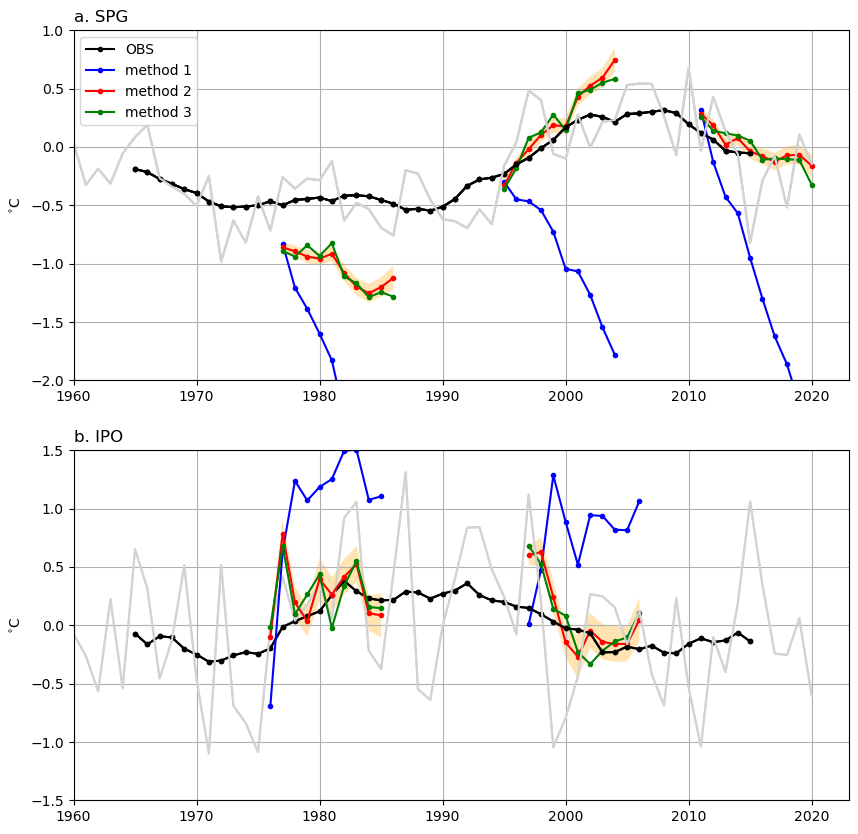

In [50]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xmin = 1960
xmax = 2023

thisyear = 1994
dptime = cesm2dp_ann_time.sel(Y=thisyear)
tmp = spg_meth2.sel(Y=thisyear).mean('M')
tmp_sd1 = spg_meth2_1mem.sel(Y=thisyear).mean('M').std('iteration')
low = tmp-tmp_sd1
high = tmp+tmp_sd1
ax1.fill_between(dptime,low,high,fc='orange',alpha=0.3)
ax1.plot(spg_obs_sm.time,spg_obs_sm,color='k',marker='.',label='OBS')
ax1.plot(spg_obs.time,spg_obs,color='lightgrey')
ax1.plot(dptime,spg_meth1.sel(Y=thisyear).mean('M'),marker='.',color='b',label='method 1')
ax1.plot(dptime,spg_meth2.sel(Y=thisyear).mean('M'),marker='.',color='r',label='method 2')
ax1.plot(dptime,spg_meth3.sel(Y=thisyear).mean('M'),marker='.',color='g',label='method 3')

thisyear = 2010
dptime = cesm2dp_ann_time.sel(Y=thisyear)
tmp = spg_meth2.sel(Y=thisyear).mean('M')
tmp_sd1 = spg_meth2_1mem.sel(Y=thisyear).mean('M').std('iteration')
low = tmp-tmp_sd1
high = tmp+tmp_sd1
ax1.fill_between(dptime,low,high,fc='orange',alpha=0.3)
ax1.plot(spg_obs_sm.time,spg_obs_sm,color='k',marker='.')
ax1.plot(spg_obs.time,spg_obs,color='lightgrey')
ax1.plot(dptime,spg_meth1.sel(Y=thisyear).mean('M'),marker='.',color='b')
ax1.plot(dptime,spg_meth2.sel(Y=thisyear).mean('M'),marker='.',color='r')
ax1.plot(dptime,spg_meth3.sel(Y=thisyear).mean('M'),marker='.',color='g')

thisyear = 1976
dptime = cesm2dp_ann_time.sel(Y=thisyear)
tmp = spg_meth2.sel(Y=thisyear).mean('M')
tmp_sd1 = spg_meth2_1mem.sel(Y=thisyear).mean('M').std('iteration')
low = tmp-tmp_sd1
high = tmp+tmp_sd1
ax1.fill_between(dptime,low,high,fc='orange',alpha=0.3)
ax1.plot(spg_obs_sm.time,spg_obs_sm,color='k',marker='.')
ax1.plot(spg_obs.time,spg_obs,color='lightgrey')
ax1.plot(dptime,spg_meth1.sel(Y=thisyear).mean('M'),marker='.',color='b')
ax1.plot(dptime,spg_meth2.sel(Y=thisyear).mean('M'),marker='.',color='r')
ax1.plot(dptime,spg_meth3.sel(Y=thisyear).mean('M'),marker='.',color='g')

ax1.set_ylabel(r'$^{\circ}$C')
ax1.set_ylim(-2,1.)
#ax1.set_xticks(xticks)
ax1.set_xlim(xmin,xmax)
ax1.legend(loc='upper left')
ax1.set_title('a. SPG',loc='left')
#ax1.set_title('Monthly Nino-3.4 SST',loc='center')
ax1.grid()

thisyear = 1996
dptime = cesm2dp_ann_time.sel(Y=thisyear)
tmp = ipo_meth2.sel(Y=thisyear).mean('M')
tmp_sd1 = ipo_meth2_1mem.sel(Y=thisyear).mean('M').std('iteration')
low = tmp-tmp_sd1
high = tmp+tmp_sd1
ax2.fill_between(dptime,low,high,fc='orange',alpha=0.3)
ax2.plot(ipo_obs_sm.time,ipo_obs_sm,color='k',marker='.',label='OBS')
ax2.plot(ipo_obs.time,ipo_obs,color='lightgrey')
ax2.plot(dptime,ipo_meth1.sel(Y=thisyear).mean('M'),marker='.',color='b',label='method 1')
ax2.plot(dptime,ipo_meth2.sel(Y=thisyear).mean('M'),marker='.',color='r',label='method 2')
ax2.plot(dptime,ipo_meth3.sel(Y=thisyear).mean('M'),marker='.',color='g',label='method 3')

thisyear = 1975
dptime = cesm2dp_ann_time.sel(Y=thisyear)
tmp = ipo_meth2.sel(Y=thisyear).mean('M')
tmp_sd1 = ipo_meth2_1mem.sel(Y=thisyear).mean('M').std('iteration')
low = tmp-tmp_sd1
high = tmp+tmp_sd1
ax2.fill_between(dptime,low,high,fc='orange',alpha=0.3)
ax2.plot(ipo_obs_sm.time,ipo_obs_sm,color='k',marker='.')
ax2.plot(ipo_obs.time,ipo_obs,color='lightgrey')
ax2.plot(dptime,ipo_meth1.sel(Y=thisyear).mean('M'),marker='.',color='b')
ax2.plot(dptime,ipo_meth2.sel(Y=thisyear).mean('M'),marker='.',color='r')
ax2.plot(dptime,ipo_meth3.sel(Y=thisyear).mean('M'),marker='.',color='g')

ax2.set_ylabel(r'$^{\circ}$C')
ax2.set_ylim(-1.5,1.5)
#ax1.set_xticks(xticks)
ax2.set_xlim(xmin,xmax)
#ax2.legend(loc='lower left')
ax2.set_title('b. IPO',loc='left')
#ax1.set_title('Monthly Nino-3.4 SST',loc='center')
ax2.grid()

plt.savefig('Fig12.png')

## MSSS Skill

In [51]:
%%time
method23_skill = stat.compute_skillcompare_monthly(cesm2dp_anom_meth3,cesm2dp_anom_meth2,nleads=10,resamp=0,detrend=False)
method23_skill = method23_skill.load()

CPU times: user 3.43 s, sys: 274 ms, total: 3.7 s
Wall time: 13.9 s


In [52]:
%%time
method21_skill = stat.compute_skillcompare_monthly(cesm2dp_anom_meth1,cesm2dp_anom_meth2,nleads=10,resamp=0,detrend=False)
method21_skill = method21_skill.load()

CPU times: user 2.17 s, sys: 203 ms, total: 2.38 s
Wall time: 7.08 s


In [53]:
%%time
method22_1mem_skill = stat.compute_skillcompare_monthly(cesm2dp_anom_meth2_1mem,cesm2dp_anom_meth2,nleads=10,resamp=0,detrend=False)
method22_1mem_skill = method22_1mem_skill.mean('iteration').load()

CPU times: user 28.5 s, sys: 1.4 s, total: 29.9 s
Wall time: 46.1 s


In [54]:
%%time
method22_2mem_skill = stat.compute_skillcompare_monthly(cesm2dp_anom_meth2_2mem,cesm2dp_anom_meth2,nleads=10,resamp=0,detrend=False)
method22_2mem_skill = method22_2mem_skill.mean('iteration').load()

CPU times: user 26.9 s, sys: 1.31 s, total: 28.3 s
Wall time: 41.5 s


## Figure 11

CPU times: user 27.9 s, sys: 389 ms, total: 28.2 s
Wall time: 31.5 s


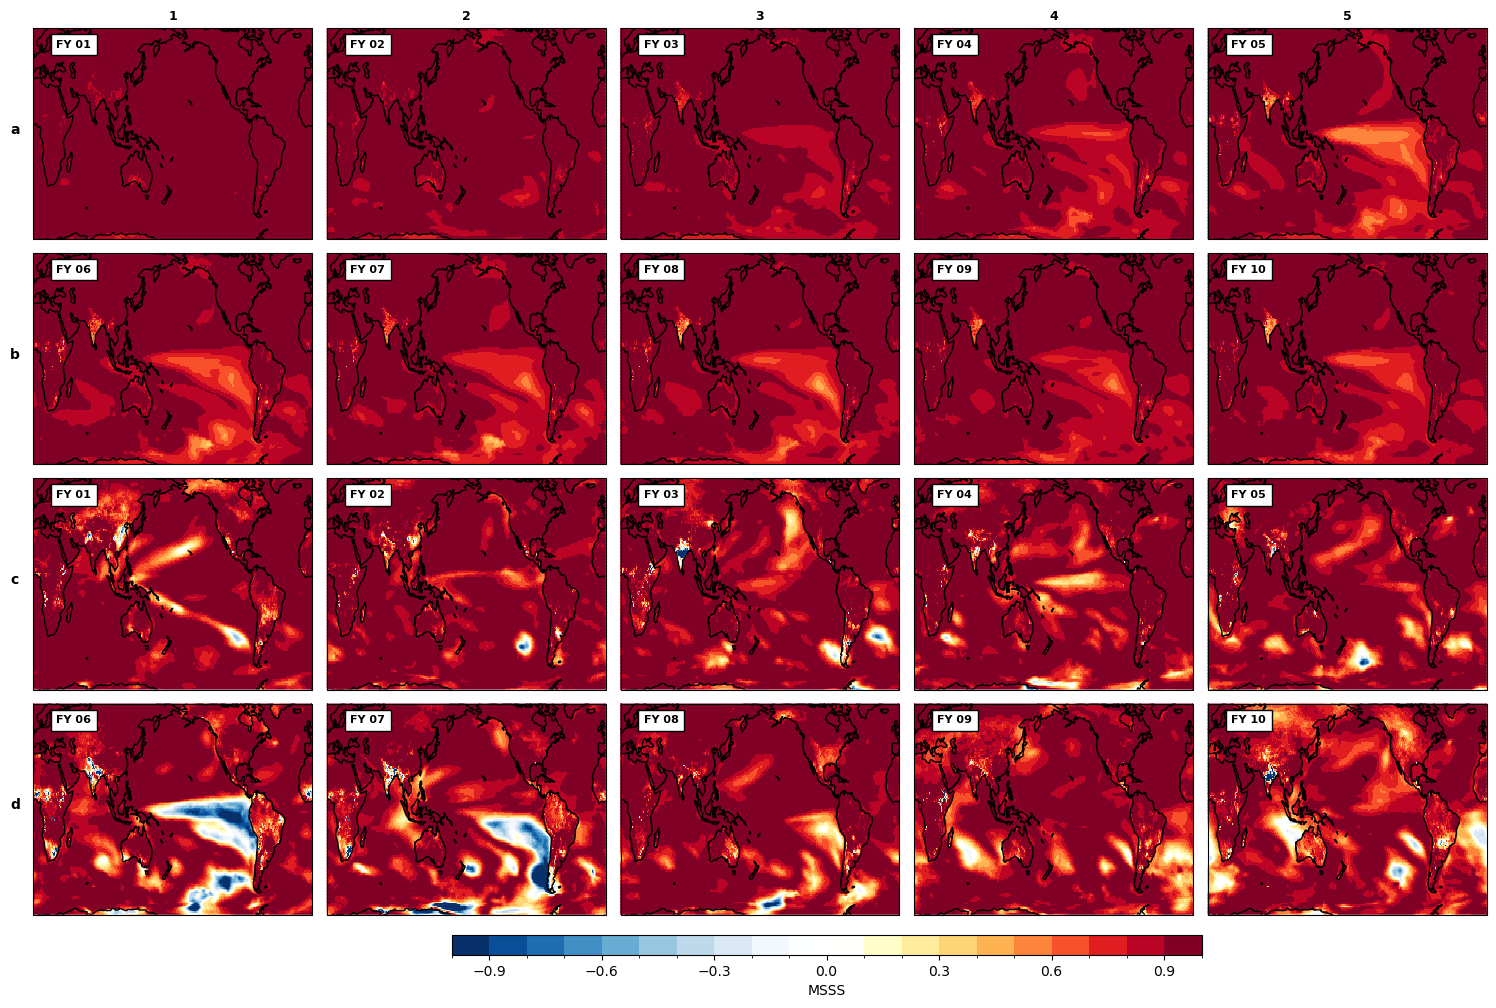

In [55]:
%%time
ci = 0.1
cmin = -1
cmax = 1

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=5

proj = ccrs.PlateCarree(central_longitude=180)

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = method22_1mem_skill['msss']
for i in range(10):
    leadstr = 'FY '+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=i), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<5):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 5): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,57,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-70,70])

tmp = method23_skill['msss']
for i in range(10):
    leadstr = 'FY '+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=i),lon, lat,ci,cmin,cmax,'',nrows,ncols,i+11,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 5): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,57,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-70,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'MSSS', orientation='horizontal')

plt.savefig('Fig11.png')

## Supplementary Figure 10

CPU times: user 27.5 s, sys: 226 ms, total: 27.7 s
Wall time: 30.3 s


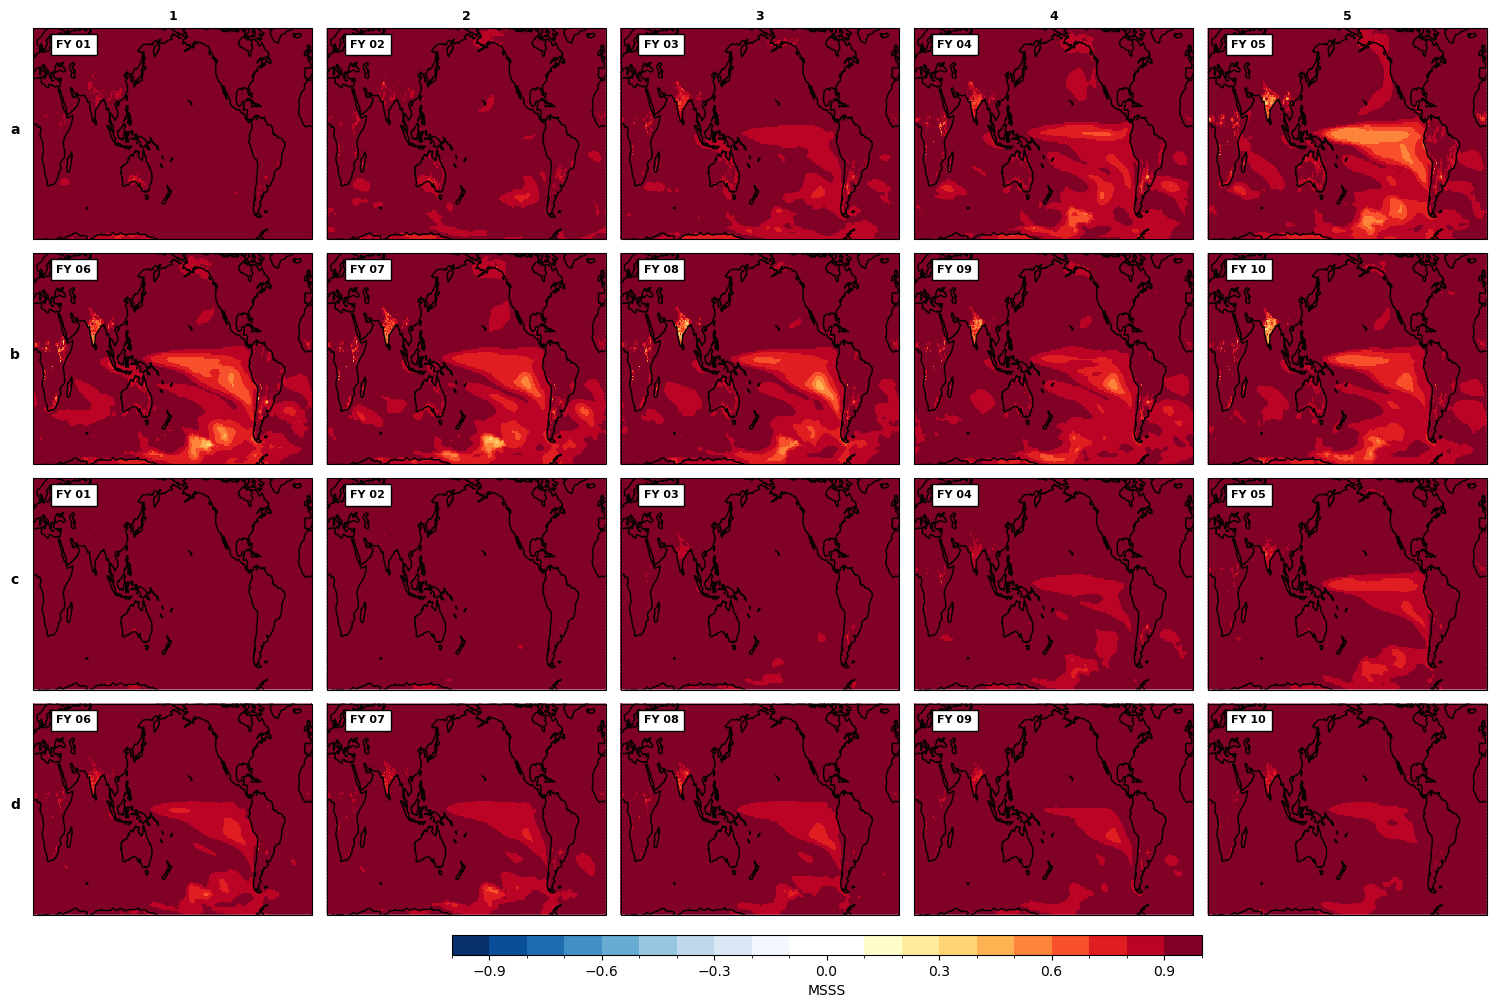

In [56]:
%%time
ci = 0.1
cmin = -1
cmax = 1

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=5

proj = ccrs.PlateCarree(central_longitude=180)

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = method22_1mem_skill['msss']
for i in range(10):
    leadstr = 'FY '+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=i), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<5):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 5): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,57,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-70,70])

tmp = method22_2mem_skill['msss']
for i in range(10):
    leadstr = 'FY '+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=i),lon, lat,ci,cmin,cmax,'',nrows,ncols,i+11,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 5): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,57,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-70,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'MSSS', orientation='horizontal')

plt.savefig('Fig_supp10.png')